In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
import uuid

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset from file path
file_path = "/content/Walmart.csv"
df = pd.read_csv(file_path)

In [ ]:
# --- Exploratory Data Analysis (EDA) ---
# 1. Display basic info and summary statistics
print("Dataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

# 2. Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# 3. Convert Date to datetime and extract temporal features
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Is_Holiday_Week'] = df['Holiday_Flag'].astype(int)

# 4. Add Holiday_Season and lagged holiday flags
df['Holiday_Season'] = 0
for i in range(len(df)):
    if df.iloc[i]['Holiday_Flag'] == 1 or (i > 0 and df.iloc[i-1]['Holiday_Flag'] == 1) or (i < len(df)-1 and df.iloc[i+1]['Holiday_Flag'] == 1):
        df.loc[df.index[i-2:i+2], 'Holiday_Season'] = 1
for lag in range(1, 4):
    df[f'Lag_Holiday_{lag}'] = df.groupby('Store')['Holiday_Flag'].shift(lag).fillna(0)

# 5. Add Weekly_Sales_Diff, Rolling_Mean_26, and Rolling_Std_26
df['Weekly_Sales_Diff'] = df.groupby('Store')['Weekly_Sales'].shift(1).diff().fillna(0)
df['Rolling_Mean_26'] = df.groupby('Store')['Weekly_Sales'].shift(1).rolling(window=26, min_periods=1).mean()
df['Rolling_Std_26'] = df.groupby('Store')['Weekly_Sales'].shift(1).rolling(window=26, min_periods=1).std().fillna(0)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None

Summary Statistics:
             Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03   6435.000000  6435.000000  6435.000000   
mean     23.000000  1.046965e+06      0.069930    60.663782     3.358607   
std      12.988182  5.643666e+05      0.255049    18.444933     0.459020   
min       1.000000  2.099862e+05      0.000000    -2.060

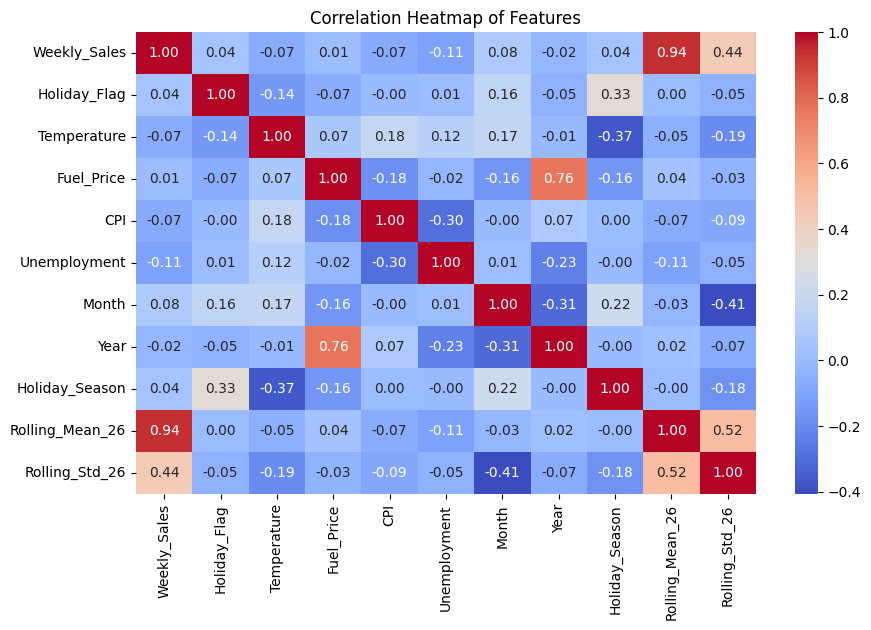

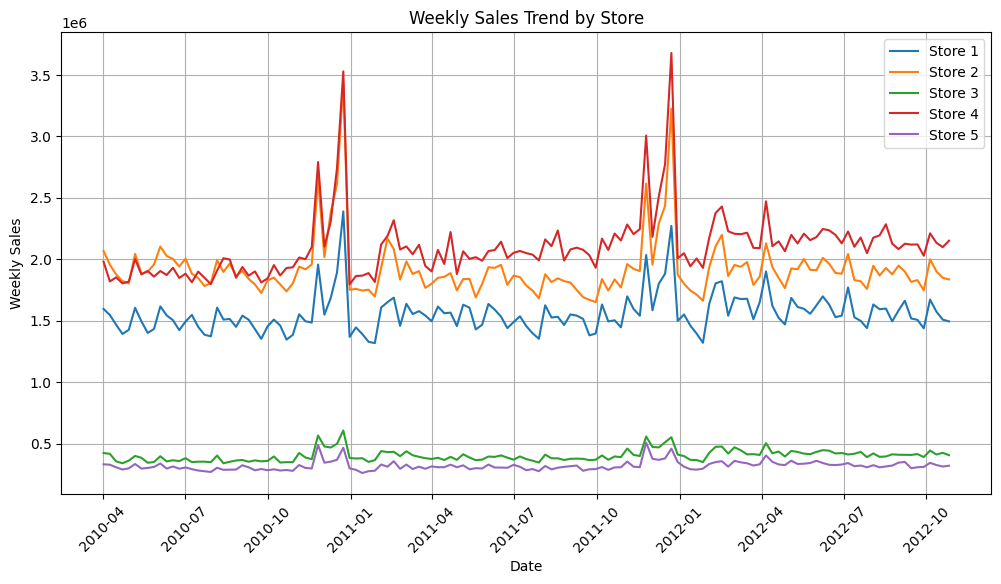

<ipython-input-21-0ece6dcaf7a8>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Holiday_Flag', y='Weekly_Sales', inner='quartile', palette='pastel')


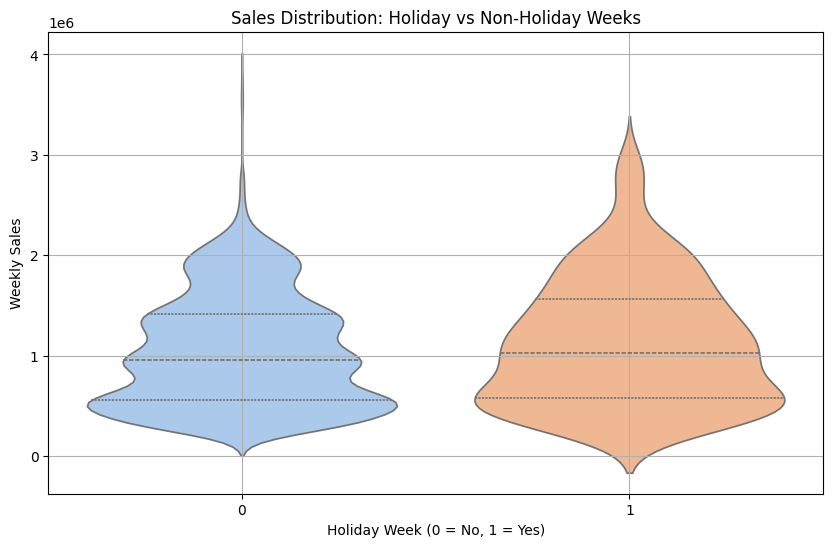

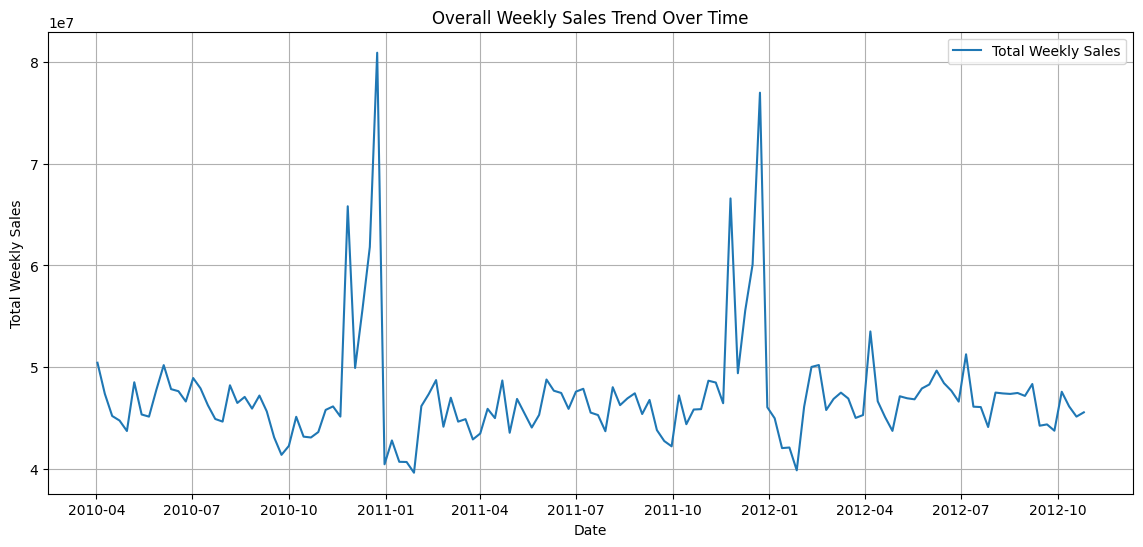

In [ ]:
# --- Exploratory Data Analysis (EDA) Visualizations ---
# Visualization 1: Correlation Heatmap
plt.figure(figsize=(10, 6))
correlation_matrix = df[['Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'Year', 'Holiday_Season', 'Rolling_Mean_26', 'Rolling_Std_26']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()
plt.close()

# Visualization 2: Weekly Sales Trend per Store
plt.figure(figsize=(12, 6))
for store in df['Store'].unique()[:5]:  # Plot first 5 stores
    store_data = df[df['Store'] == store]
    plt.plot(store_data['Date'], store_data['Weekly_Sales'], label=f'Store {store}')
plt.title('Weekly Sales Trend by Store')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Holiday_Flag', y='Weekly_Sales', inner='quartile', palette='pastel')
plt.title('Sales Distribution: Holiday vs Non-Holiday Weeks')
plt.xlabel('Holiday Week (0 = No, 1 = Yes)')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
df_grouped = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
plt.plot(df_grouped['Date'], df_grouped['Weekly_Sales'], label='Total Weekly Sales')
plt.title('Overall Weekly Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.grid(True)
plt.legend()
plt.show()



In [ ]:
# --- Data Preprocessing ---
# Sort by Store and Date
df = df.sort_values(by=['Store', 'Date'])

# Create lagged features (previous 1 to 8 weeks' sales)
for lag in range(1, 9):
    df[f'Lag_{lag}'] = df.groupby('Store')['Weekly_Sales'].shift(lag)
df = df.dropna().reset_index(drop=True)

# Normalize Store feature (placeholder, will scale after split)
df['Store_Norm'] = df['Store']

# Select features and target
numeric_features = ['Store_Norm', 'Holiday_Flag', 'Is_Holiday_Week', 'Holiday_Season'] + [f'Lag_Holiday_{lag}' for lag in range(1, 4)] + ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'Year', 'Weekly_Sales_Diff', 'Rolling_Mean_26', 'Rolling_Std_26'] + [f'Lag_{lag}' for lag in range(1, 9)]
target = 'Weekly_Sales'

# Prepare features and target
X = df[numeric_features].reset_index(drop=True)
y = df[[target]].reset_index(drop=True)



In [ ]:
# Create sequences for LSTM
def create_sequences(X, y, time_steps=52):
    Xs, ys = [], []
    store_groups = df.groupby('Store')
    for store, group in store_groups:
        X_store = X.loc[group.index]
        y_store = y.loc[group.index]
        for i in range(len(X_store) - time_steps):
            Xs.append(X_store.iloc[i:(i + time_steps)].values)
            ys.append(y_store.iloc[i + time_steps].values)
    return np.array(Xs), np.array(ys)

time_steps = 52
X_seq, y_seq = create_sequences(X, y, time_steps)

In [ ]:
# Split into train and test sets (80-20)
train_size = int(0.8 * len(X_seq))
test_size = len(X_seq) - train_size

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_test = X_seq[train_size:]
y_test = y_seq[train_size:]

print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")

# Normalize features and target after splitting
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on training data only
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = scaler_y.fit_transform(y_train)

# Transform test data using the same scalers
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = scaler_y.transform(y_test)



Train shape: (2988, 52, 24), Test shape: (747, 52, 24)


In [ ]:
# --- Build and Train LSTM Model ---
lstm_model = Sequential([
    Bidirectional(LSTM(64, activation='tanh', input_shape=(time_steps, X_train.shape[2]), return_sequences=True)),
    BatchNormalization(),
    Dropout(0.35),
    LSTM(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    Dropout(0.35),
    LSTM(32, activation='tanh'),
    BatchNormalization(),
    Dropout(0.35),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
lstm_model.summary()

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)

# Train the LSTM model
history = lstm_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - loss: 1.1762
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - loss: 0.2991
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - loss: 0.1819
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - loss: 0.1144
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0910
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.0700
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - loss: 0.0589
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - loss: 0.0501
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0439
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.0357
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.0315
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - loss: 0.0310
Epoch 13/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - loss: 0.0260
Epoch 14/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.0244
Epoch 15/100
94/94 ━━━━━━━━━━━━━━━━

In [ ]:
# --- Generate LSTM Predictions ---
y_pred_lstm_scaled = lstm_model.predict(X_test_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)
y_pred_lstm_inv = scaler_y.inverse_transform(y_pred_lstm_scaled)

# --- Prepare Data for XGBoost ---
# Flatten the last time step of each sequence for XGBoost
X_train_flat = X_train_scaled[:, -1, :]
X_test_flat = X_test_scaled[:, -1, :]

# Add LSTM predictions as a feature
y_pred_lstm_train = lstm_model.predict(X_train_scaled)
y_pred_lstm_train_flat = y_pred_lstm_train.reshape(-1)
y_pred_lstm_test_flat = y_pred_lstm_scaled.reshape(-1)

X_train_xgb = np.column_stack((X_train_flat, y_pred_lstm_train_flat))
X_test_xgb = np.column_stack((X_test_flat, y_pred_lstm_test_flat))

y_train_xgb = y_train_scaled.reshape(-1)
y_test_xgb = y_test_scaled.reshape(-1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


In [ ]:
# --- Build and Train XGBoost Model ---
# --- Build and Train XGBoost Model with Hyperparameter Tuning ---
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

# Create base model
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42)

In [ ]:
# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the randomized search model
random_search.fit(X_train_xgb, y_train_xgb)

# Use best model from search
xgb_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'colsample_bytree': np.float64(0.6624074561769746), 'learning_rate': np.float64(0.05679835610086079), 'max_depth': 5, 'n_estimators': 252, 'subsample': np.float64(0.9464704583099741)}


In [ ]:
# --- Generate Hybrid Predictions ---
y_pred_xgb_scaled = xgb_model.predict(X_test_xgb)
y_pred_xgb_inv = scaler_y.inverse_transform(y_pred_xgb_scaled.reshape(-1, 1))

# --- Evaluate the Hybrid Model ---
mae = mean_absolute_error(y_test_inv, y_pred_xgb_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_xgb_inv))
r2 = r2_score(y_test_inv, y_pred_xgb_inv)

print("\n🔧 Tuned Hybrid Test Set Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")


# --- Generate Hybrid Predictions ---
y_pred_xgb_scaled = xgb_model.predict(X_test_xgb)
y_pred_xgb_inv = scaler_y.inverse_transform(y_pred_xgb_scaled.reshape(-1, 1))

# --- Evaluate the Hybrid Model ---
mae = mean_absolute_error(y_test_inv, y_pred_xgb_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_xgb_inv))
r2 = r2_score(y_test_inv, y_pred_xgb_inv)

print("\nHybrid Test Set Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")

# Save metrics to file
with open('/content/evaluation_metrics_hybrid.txt', 'w') as f:
    f.write(f"Hybrid Test Set - Mean Absolute Error (MAE): ${mae:.2f}\n")
    f.write(f"Hybrid Test Set - Root Mean Squared Error (RMSE): ${rmse:.2f}\n")
    f.write(f"Hybrid Test Set - R-squared (R²): {r2:.4f}\n")


🔧 Tuned Hybrid Test Set Evaluation Metrics:
Mean Absolute Error (MAE): $47220.38
Root Mean Squared Error (RMSE): $72676.68
R-squared (R²): 0.9676

Hybrid Test Set Evaluation Metrics:
Mean Absolute Error (MAE): $47220.38
Root Mean Squared Error (RMSE): $72676.68
R-squared (R²): 0.9676


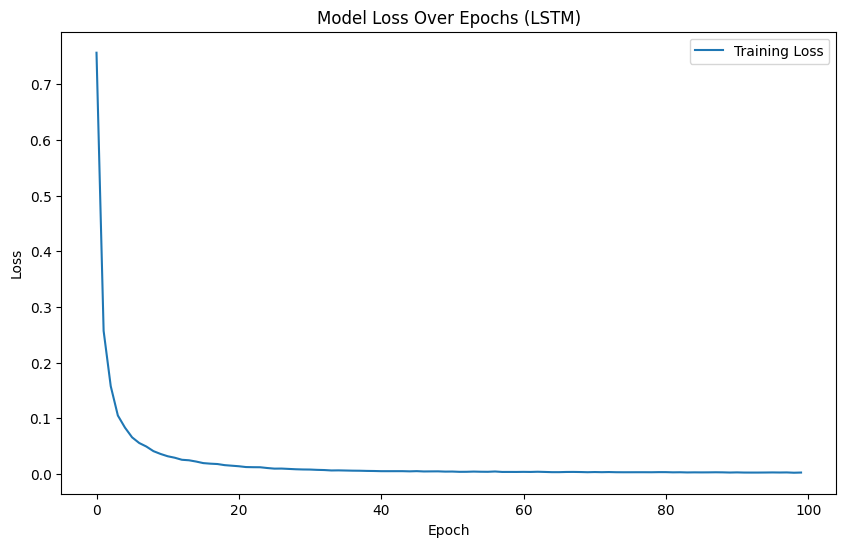

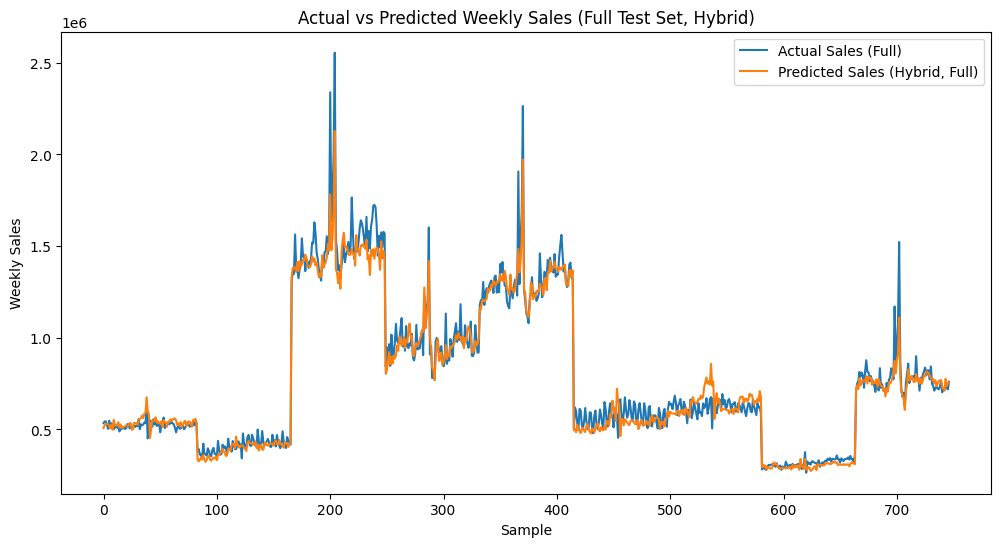

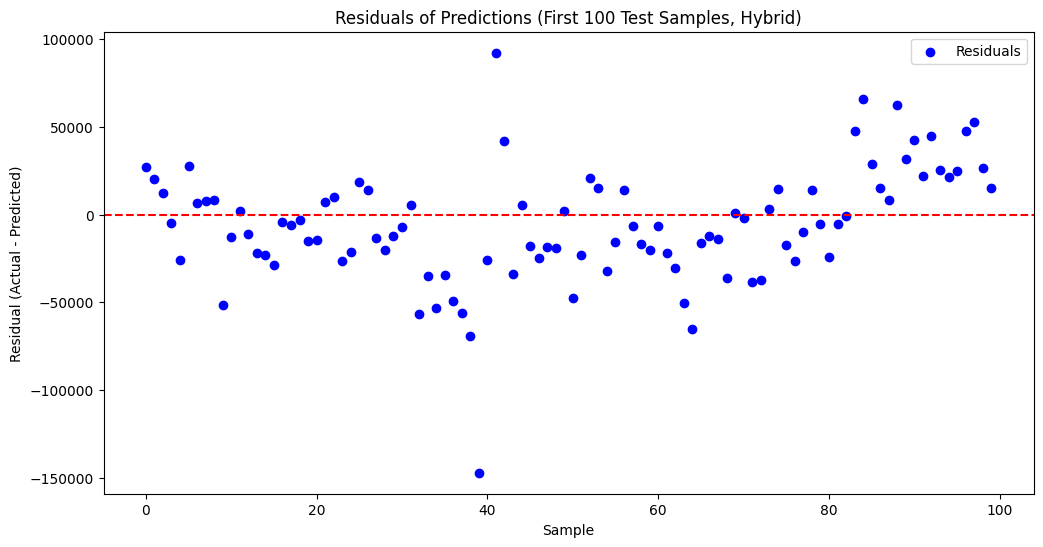

In [ ]:
# Plot training history (LSTM)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss Over Epochs (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.close()

# Plot predictions vs actuals (Hybrid, full test set)
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Sales (Full)')
plt.plot(y_pred_xgb_inv, label='Predicted Sales (Hybrid, Full)')
plt.title('Actual vs Predicted Weekly Sales (Full Test Set, Hybrid)')
plt.xlabel('Sample')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()
plt.close()

# Residual plot (Hybrid)
residuals = y_test_inv[:100] - y_pred_xgb_inv[:100]
plt.figure(figsize=(12, 6))
plt.scatter(range(100), residuals, c='blue', label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals of Predictions (First 100 Test Samples, Hybrid)')
plt.xlabel('Sample')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend()
plt.show()
plt.close()

# Save the models
lstm_model.save('/content/walmart_lstm_model_hybrid.h5')
xgb_model.save_model('/content/walmart_xgboost_model_hybrid.json')

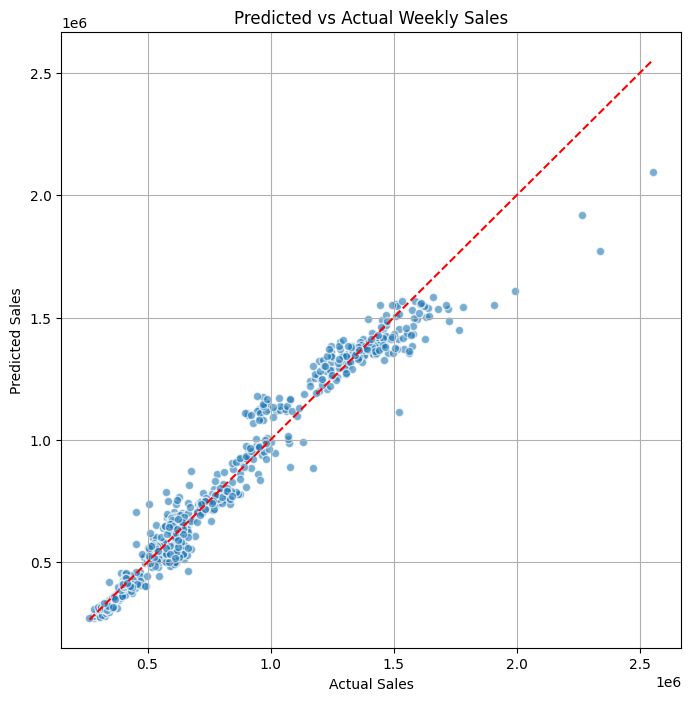

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test_inv, y_pred_xgb_inv, alpha=0.6, edgecolors='w')
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')
plt.title('Predicted vs Actual Weekly Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.grid(True)
plt.show()
